In [1]:
# Create a LSTM model to predict the next bit of a LFSR
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


def create_data(num_samples=10000, initial_key1=None, initial_key2=None, initial_key3=None,ln=5):
    if initial_key1 is None:
        initial_key1 = np.random.randint(0, 2, 19)
        print("Initial key 1: ", initial_key1)
    if initial_key2 is None:
        initial_key2 = np.random.randint(0, 2, 22)
        print("Initial key 2: ", initial_key2)
    if initial_key3 is None:
        initial_key3 = np.random.randint(0, 2, 23)
        print("Initial key 3: ", initial_key3)

    # data = initial_key
    key1 = initial_key1
    key2 = initial_key2
    key3 = initial_key3
    x = []
    y = []
    data = []
    for _ in range(num_samples):
        nxt1 = (
            key1[0]
            ^ key1[1]
            ^ key1[2]
            ^ key1[5]
        )
        nxt2 = key2[0] ^ key2[1]
        nxt3 = key3[0] ^ key3[1] ^ key3[2] ^ key3[15]
        data.append(nxt1 ^ nxt2 ^ nxt3)
        if len(data) >= ln + 1:
            x.append(data[-(ln + 1) : -1])
            y.append(data[-1])
        key1 = np.roll(key1, -1)
        key2 = np.roll(key2, -1)
        key3 = np.roll(key3, -1)
        key1[-1] = nxt1
        key2[-1] = nxt2
        key3[-1] = nxt3
        

    return np.array(x), np.array(y)

2024-04-10 16:51:06.735913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 16:51:08.812800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-04-10 16:51:08.812950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
ln = 64
X, Y = create_data(
    5000000,
    ln=ln,
    # initial_key1=np.array([1, 0, 1, 1, 1]),
    # initial_key2=np.array([1, 1, 1, 0, 1]),
)
X_train, Y_train = X[: 4000000 - ln], Y[: 4000000 - ln]
X_test, Y_test = X[4000000 - ln :], Y[4000000 - ln :]
print(X.shape)

Initial key 1:  [1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1]
Initial key 2:  [0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0]
Initial key 3:  [1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1]
(4999936, 64)


In [7]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(1000, input_shape=(ln,), activation="relu"),
        # tf.keras.layers.Embedding(2, 5, input_length=5),
        # tf.keras.layers.LSTM(5),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

ValueError: Input 0 of layer "simple_rnn" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [6]:
model.fit(X_train, Y_train, epochs=8, validation_data=(X_test, Y_test))

Epoch 1/8


2024-04-10 16:54:47.663202: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x150f98151870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 16:54:47.663251: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-04-10 16:54:47.667861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 16:54:47.792953: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124998/124998 [==============================] - 485s 4ms/step - loss: 0.6937 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.5006
Epoch 2/8
  8268/124998 [>.............................] - ETA: 6:30 - loss: 0.6932 - accuracy: 0.4986


KeyboardInterrupt



In [29]:
lengths = []
accuracies = []
losses = []
tf.keras.utils.disable_interactive_logging()
for ln in range(10, 21):
    print(f"{ln - 10}/11", end="\r")
    X, Y = create_data(
        100000,
        ln=ln,
        # initial_key1=np.array([1, 0, 1, 1, 1]),
        # initial_key2=np.array([1, 1, 1, 0, 1]),
    )
    X_train, Y_train = X[: 50000 - ln], Y[: 50000 - ln]
    X_test, Y_test = X[50000 - ln :], Y[50000 - ln :]
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(1000, input_shape=(ln,), activation="relu"),
            # tf.keras.layers.Embedding(2, 5, input_length=ln),
            # tf.keras.layers.LSTM(5),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    # model.summary()
    callback = tf.keras.callbacks.ModelCheckpoint(
        "model.h5", monitor="val_loss", save_best_only=True, mode="min"
    )
    model.fit(
        X_train,
        Y_train,
        epochs=5,
        validation_data=(X_test, Y_test),
        callbacks=[callback],
    )
    model = tf.keras.models.load_model("model.h5")
    l, ac = model.evaluate(X_test, Y_test)
    lengths.append(ln)
    accuracies.append(ac)
    losses.append(l)

Initial key 1:  [1 0 0 0 0 0 0 1 0 0]
Initial key 2:  [1 0 1 1 1 0 1 0 1 1]
Initial key 1:  [1 1 1 1 0 1 0 1 1 1]
Initial key 2:  [0 0 0 0 0 0 1 0 0 1]
Initial key 1:  [1 1 0 0 1 0 1 1 0 1]
Initial key 2:  [1 1 1 0 1 1 0 0 0 0]
Initial key 1:  [1 1 0 1 0 1 0 0 1 1]
Initial key 2:  [0 1 1 1 0 1 1 0 0 0]
Initial key 1:  [0 1 0 0 0 1 0 1 1 0]
Initial key 2:  [1 1 1 1 0 1 0 0 0 0]
Initial key 1:  [1 0 1 0 1 0 1 1 1 0]
Initial key 2:  [1 1 0 0 1 0 1 0 1 1]
Initial key 1:  [1 1 0 1 1 0 0 1 0 0]
Initial key 2:  [1 1 0 0 1 0 1 1 1 1]
Initial key 1:  [1 1 0 1 0 1 0 0 0 1]
Initial key 2:  [1 1 1 1 1 0 0 1 1 0]
Initial key 1:  [0 1 1 0 0 1 0 0 1 0]
Initial key 2:  [1 1 0 0 0 0 1 1 1 0]
Initial key 1:  [1 1 1 0 0 1 0 0 0 1]
Initial key 2:  [0 1 1 0 0 1 1 0 1 1]
Initial key 1:  [1 0 1 1 1 1 0 0 0 0]
Initial key 2:  [1 1 1 1 0 0 0 0 0 0]


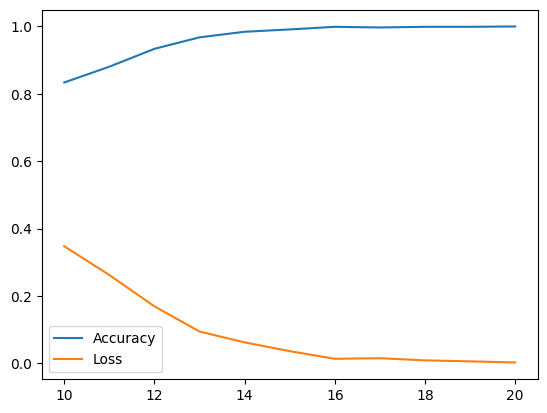

In [30]:
import matplotlib.pyplot as plt

plt.plot(lengths, accuracies)
plt.plot(lengths, losses)
plt.legend(["Accuracy", "Loss"])
plt.show()

Sequence length: 11000


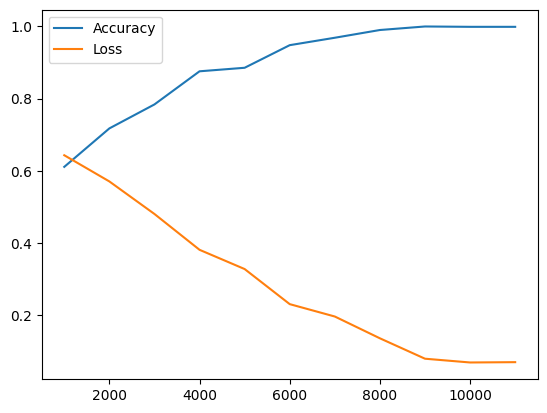

Initial key 1:  [0 1 1 1 1 1 0 1 1 1]
Initial key 2:  [1 1 0 0 1 1 1 0 0 1]


KeyboardInterrupt: 

In [32]:
lengths = []
accuracies = []
losses = []
from IPython.display import clear_output

# tf.keras.utils.enable_interactive_logging()
for sq_ln in range(1000, 50001, 1000):

    ln = 20

    X, Y = create_data(
        100000,
        ln=ln,
        # initial_key1=np.array([1, 0, 1, 1, 1]),
        # initial_key2=np.array([1, 1, 1, 0, 1]),
    )
    X_train, Y_train = X[: sq_ln - ln], Y[: sq_ln - ln]
    X_test, Y_test = X[sq_ln - ln :], Y[sq_ln - ln :]
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(4000, input_shape=(ln,), activation="relu"),
            # tf.keras.layers.Embedding(2, 5, input_length=ln),
            # tf.keras.layers.LSTM(5),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    # model.summary()
    callback = tf.keras.callbacks.ModelCheckpoint(
        "model.h5", monitor="val_loss", save_best_only=True, mode="min"
    )
    model.fit(
        X_train,
        Y_train,
        epochs=5,
        validation_data=(X_test, Y_test),
        callbacks=[callback],
    )
    model = tf.keras.models.load_model("model.h5")
    l, ac = model.evaluate(X_test, Y_test)
    lengths.append(sq_ln)
    accuracies.append(ac)
    losses.append(l)
    clear_output(wait=True)
    plt.plot(lengths, accuracies)
    plt.plot(lengths, losses)
    plt.legend(["Accuracy", "Loss"])
    print(f"Sequence length: {sq_ln}")
    plt.show()

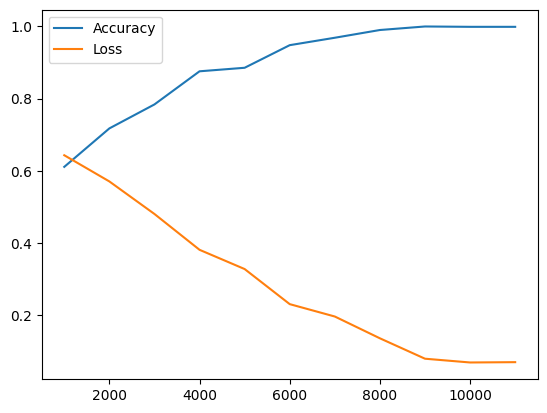

In [35]:
plt.plot(lengths, accuracies)
plt.plot(lengths, losses)
plt.legend(["Accuracy", "Loss"])
plt.show()
# print(accuracies)

In [26]:
X, Y = create_data(100000, ln=20)
model.evaluate(X, Y)

Initial key 1:  [0 0 1 0 0 1 0 1 0 0]
Initial key 2:  [0 1 1 1 0 0 0 1 0 0]
3125/3125 [==============================] - 8s 3ms/step - loss: 5.5383 - accuracy: 0.5063


[5.538252830505371, 0.5063112378120422]

In [ ]:
tl, tac = 0, 0
for i in range(1024):
    keys = np.binary_repr(i, width=10)
    keys = np.array([int(k) for k in keys])
    key1 = keys[:5]
    key2 = keys[5:]
    X, Y = create_data(
        10000,
        ln=15,
        initial_key1=key1,
        initial_key2=key2,
    )
    l, ac = model.evaluate(X, Y)
    print(l,ac)
    tl += l
    tac += ac
print("Total Loss and Accuracy: ", tl/1024, tac/1024)    